# Real-Time Time Dependent Density Functional Theory calculations for $HeH+$

The following notebook is designed to explain the RT-TDDFT method used in the PyRTP program, as well as CP2K. With this, it is hoped that the user should be able to gain a good understanding of this method and be able to use the PyRTP program to perform simple RT-TDDFT calculations.

### A Foreword
This notebook will not go into great detail on the DFT method which is contained within the RT-TDDFT method, as an additional notebook explains this. It is advised to review that notebook first, as RT-TDDFT can be seen as a form of *extension* to conventional DFT. The code to perform these calculations will be given, however it will not be explained in detail.

## Theory
The overall purpose of RT-TDDFT is to solve the Time-Dependent Schrödinger Equation (TDSE), which is given by the following:
\begin{align*}
i\hbar\frac{\partial\Psi}{\partial t}=\hat{H}\Psi
\end{align*}
Such that $\Psi$ is the wavefunction, $\hat{H}$ is the Hamiltonian and $\hbar$ is the reduced Planck constant. For most systems (i.e. molecular systems), the Hamiltonian is difficult to determine, due to the difficulty in approximating the kinetic energy functional within it. As such, the Kohn-Sham formalism is used, in which the system under study is replaced with an identical, but *non-interacting*, system with the same electron density. We know that there is a one-to-one mapping between electron density and wavefunction from the first Runge-Gross theorem, which states:

"For every single-particle potential $v(\boldsymbol{r},t)$ which can be expanded into a Taylor series with respect to the time coordinate around $t=t_0$, a map $G:v(\boldsymbol{r},t)\to\rho(\boldsymbol{r},t)$ is defined by solving the time-dependent Schrödinger equation with a fixed initial state $\Phi(t_0)=\Phi_0$ and calculating the corresponding densities $\rho(\boldsymbol{r},t)$. This map can be inverted up to an additive merely time-dependent function in the potential."

This allows for the kinetic energy functional to be determined accurately, allowing for the TDSE to be written in the following form:
\begin{align*}
i\frac{\partial}{\partial t}\Psi_n^{KS}(\boldsymbol{r},t)=\hat{H}^{KS}[\rho(t),t]\Psi_n^{KS}(\boldsymbol{r},t)
\end{align*}
Thus, the system may be completely described by knowledge of the electron density over all time. We now seek to solve this equation, which we can do as shown in Appendix A, giving the following solution:
\begin{align*}
 \Psi^{KS}(\boldsymbol{r},t)=\hat{T}  \exp{\left(-i \int_{t_0}^t \text{d}\tau \,\left\{\hat{H}^{KS}[\rho(\tau),\tau]\right\}\right)} \Psi^{KS}(\boldsymbol{r},t_0)
\end{align*}
Such that $\hat{U}(t,t_0)=\hat{T}  \exp{\left(-i \int_{t_0}^t \text{d}\tau \,\left\{\hat{H}^{KS}[\rho(\tau),\tau]\right\}\right)}$. This term is referred to as the *exact propagator*, as it is the exact operator which transforms $\Psi^{KS}(\boldsymbol{r},t_0)$ into $\Psi^{KS}(\boldsymbol{r},t)$, or move the system in time from $t_0$ to $t$. We can solve this over a period of time using the following method:

1. Use DFT to solve for the ground-state 
	* This is our starting point, as it gives us an electron density and Hamiltonian to work with.

2. Apply some energy to the system
	* This is to ensure the system *actually moves*. If we propagate the ground state forward in time, nothing will happen, as the system is in equilibrium. By giving the system some energy (usually in the form of a short electric field pulse), the electrons in the system enter an excited state, and the system moves around and evolves.


3. Propagate the wavefunction (and thus the density matrix) in time
	* Given the equation we found earlier, we can solve numerically for the wavefunction at each increment of time, in order to show the evolution of the system.


4. Collect any useful information about the system
	* Throughout the course of propagating the system, we can use the wavefunction and electron density to determine various useful properties of the system, such as the dipole moment, charge distribution, etc. From this, we can determine other time-dependent properties of the system, which would not be available in a method such as DFT, which is, by definition, somewhat static.

Using this theoretical method, we can now design a computational method to perform this calculation.

## Computational Method
This program uses the following packages (you can install through Anaconda Navigator or through the terminal if you don't already have them installed):

In [2]:
import math # For general math operations
import numpy as np # For fast math operations using BLAS (i.e. sums, means, etc.)
import scipy # For general purpose maths, which sometimes works better than Numpy (FFTs specifically)
from scipy.interpolate import lagrange # Specifically importing the lagrange function to save space later on in the program
from sympy import Matrix # For general matrix manipulation (diagonalisation, etc).
import pylibxc # Python interpretter for the LibXC exchange-correlation potentials library
import os # Mostly used to create files and directories
from npy_append_array import NpyAppendArray # Used to save data as external arrays regularly in case of failure to run
import matplotlib.pyplot as plt # Used for post-processing of data
import time # Used to check run times of certain functions
from numba import jit,objmode # Translates Python script into machine code for significantly faster runtimes

We now must compute the ground state electron density (represented by the density matrix $\boldsymbol{P}$). The following code block contains the functions to calculate this, which for the purpose of understanding RT-TDDFT, we do not need to know how it works exactly (for further information on how DFT works, please see the other notebook).

In [7]:
# DFT calculation functions

def GridCreate(L,N_i):
    # This function takes the length of the grid and the number of points per side (N_i) and forms a 3-dimensional 'box' of
    # grid points. This function does not have the @jit tag, as Numba does not support the 'np.linspace' command natively.
    # This command also returns the total number of points and the grid spacing 'dr'.
	N = N_i**3
	dr = (L/N_i)**3

	r_x = np.linspace(-L/2.,L/2.,int(N_i),endpoint=False)
	r_y = np.linspace(-L/2.,L/2.,int(N_i),endpoint=False)
	r_z = np.linspace(-L/2.,L/2.,int(N_i),endpoint=False)
    
	return r_x,r_y,r_z,N,dr


@jit(nopython=True,cache=True)
def GTO(a_GTO,r_GTO,R_GTO): 
    # This function evaluates a Gaussian-type orbital evaluated on the grid from user defined coefficients and exponents, 
    # such that a_GTO = exponent, r_GTO = grid position vector and R_GTO = nuclei position vector. 
    return (2*a_GTO/np.pi)**(3/4)*np.exp(-a_GTO*(np.linalg.norm(r_GTO - R_GTO))**2)

@jit(nopython=True,cache=True)
def construct_GTOs(nuc,N,N_i,r_x,r_y,r_z,R_I,alpha) :
    # This function evaluates the Gaussian-type orbitals for a selected molecule at each point of the grid
    # and saves it to an array. In this case, as the orbital approximation being used is STO-3G, the array
    # has dimensions {3 x N_i x N_i x N_i}, as this approximation uses 3 Gaussian functions per orbital.

    # Create a matrix of grid points for each of the three GTOs, initialised to zero.
    GTO_p = np.zeros(3*N).reshape(3,N_i,N_i,N_i)

    # Currently only working for HeH+, however this would be simple to change for other molecules.
    if nuc == 'He' :
        r_n = R_I[0]
        alpha_n = alpha[0]  
    if nuc == 'H' :
        r_n = R_I[1]
        alpha_n = alpha[1]
        
    #Loop through GTOs and grid points, calculate the GTO value and assign to GTO_p.
    for gto in range(0,3) :
        #for i,j,k in range(0,N_i) :    
        for i in range(0,N_i) : 
            for j in range(0,N_i) :
                for k in range(0,N_i) :
                    p = np.array([r_x[i],r_y[j],r_z[k]]) #Select current grid position vector.

                    GTO_p[gto][i][j][k] = GTO(alpha_n[gto],p,r_n) #calculate GTO value using GTO function call.

    return GTO_p

@jit(nopython=True,cache=True)
def construct_CGF(GTOs,N,N_i,Coef) :
    # This function evaluates the STO-3G approximation at each grid point.
    CGF = np.zeros(N).reshape(N_i,N_i,N_i) #create a matrix of grid points initialised to zero.
    for g in range(0,len(GTOs)) : CGF += Coef[g]*GTOs[g] #construct the CGF from the GTOs and coefficients, Eq. 2.
    
    return CGF

@jit(nopython=True,cache=True)
def calculate_realspace_density(phi,N,N_i,P,dr,) :
    # This function determines the electron charge density at each grid point, along with a total electron charge density.
    n_el_r = np.zeros(N).reshape(N_i,N_i,N_i)
    n_el_total = 0

    for i in range(0,len(phi)) :
        for j in range(0,len(phi)) :
            n_el_r += P[i][j]*phi[i]*phi[j]

    return n_el_r, np.sum(n_el_r)*dr

@jit(nopython=True,cache=True)
def calculate_core_density(N,N_i,Z_I,r_x,r_y,r_z,R_I) :
    # This function determines the nuclear charge density at each grid point.
    R_pp = np.sqrt(2.)/5. # This is a pseudopotential parameter, which is preset for each molecule.

    # It is worth mentioning at this point that this code is designed around simulating the HeH+ molecule. 
    # Further work is required to add the capability to simulate other molecules, which will have different
    # pseudopotential parameters.

    n_c_r = np.zeros(N).reshape(N_i,N_i,N_i)

    for i in range(0,N_i) :
        for j in range(0,N_i) :
            for k in range(0,N_i) :
                r = np.array([r_x[i],r_y[j],r_z[k]])

                for n in range(0,len(Z_I)) :
                    n_c_r[i][j][k] += -Z_I[n]/(R_pp**3)*np.pi**(-3/2)*np.exp(-((r-R_I[n])/R_pp).dot((r-R_I[n])/R_pp))

    return n_c_r

@jit(nopython=True,cache=True)
def grid_integration(V_r,dr,phi):
    # This function integrates an arbitrary potential over all points of the grid, giving a potential matrix in the
    # correct basis, which is more compact.
    V = np.zeros(len(phi)**2).reshape(len(phi),len(phi))
    
    for i in range(0,len(phi)):
        for j in range(0,len(phi)):

            V[i][j] = np.sum(np.real(V_r)*phi[i]*phi[j])*dr

    return V

@jit(nopython=True,cache=True)
def energy_calculation(V,P): 
    # This function evaluates a potential in the correct basis and determines the corresponding energy contribution. 
    return np.sum(P*V)

@jit(nopython=True,cache=True)
def calculate_overlap(N,N_i,dr,phi):
    # This function evaluates the overlap between atomic orbitals. It is worth noting that this function is simplified using
    # the grid integration function, as if the arbitrary potential being evaluated is equal to 1 at all points, the equations
    # to calculate the potential and the overlap are equivalent. Of course, this could be done explicitly in this function,
    # however it is more compact to do it this way.
    V_temp = np.ones(N).reshape(N_i,N_i,N_i)
    S = grid_integration(V_temp,dr,phi)

    return S

@jit(nopython=True,cache=True)
def calculate_kinetic_derivative(phi,phi_PW_G,N,N_i,G_u,G_v,G_w,L):
    # This function calculates the derivative of the kinetic energy by looping over all points of the reciprocal space grid.
    # 'with objmode()' is used to escape from the machine code to perform functions not available in Numba, with np.matmul being
    # somewhat awkward to use.
    delta_T = np.zeros(len(phi)**2).reshape(len(phi),len(phi))

    for i in range(0,N_i) :
        for j in range(0,N_i) :
            for k in range(0,N_i) :

                g = np.array([G_u[i],G_v[j],G_w[k]])
                for I in range(0,len(phi)) :
                    for J in range(0,len(phi)) :
                        with objmode():
                            delta_T[I][J] += 0.5*L**3/N**2*np.dot(g,g)*np.real(np.dot(np.conjugate(phi_PW_G[I][i][j][k]),phi_PW_G[J][i][j][k]))

    return delta_T

@jit(nopython=True,cache=True)
def calculate_hartree_reciprocal(n_G,N,N_i,r_x,r_y,r_z,G_u,G_v,G_w,L):
    # This function calculates the Hartree potential and energy in reciprocal space.
    with objmode(nG='complex128[:,:,:]'):
        nG = np.fft.fftshift(n_G) #n_G is shifted to match same frequency domain as G (-pi,pi) instead of (0,2pi)
    Vg = np.zeros(N).reshape(N_i,N_i,N_i).astype(np.complex128) # Arrays here are of type 'np.complex128', however we 
                                                                # eventually ignore all non-real parts.
    E_hart_G = 0. # Hartree energy in reciprocal space
    
    for i in range(0,N_i) :
        for j in range(0,N_i) :
            for k in range(0,N_i) :

                R_vec = np.array([r_x[i],r_y[j],r_z[k]]) # position vector in real space
                G_vec = np.array([G_u[i],G_v[j],G_w[k]]) # position vector in reciprocal space

                if np.dot(G_vec,G_vec) < 0.01 :  continue # Prevents a division by zero

                Vg[i][j][k] = 4*np.pi*nG[i][j][k]/np.dot(G_vec,G_vec)
                E_hart_G += np.conjugate(nG[i][j][k])*Vg[i][j][k] 
                
    E_hart_G *= L**3/N**2*0.5
    with objmode(Vout='complex128[:,:,:]'):
        Vout=np.fft.ifftshift(Vg)
    return Vout, E_hart_G #result is shifted back. 

@jit(nopython=True,cache=True)
def calculate_hartree_real(V_r,n_r,dr) :
                
    return 0.5*np.sum(V_r*n_r)*dr

def calculate_XC_pylibxc(n_el_r,N_i,dr):
    # This function uses the LibXC library to evaluate the exchange-correlation potential and energy 
    # over the entire grid. This requires the electron charge density to function. The XC functional
    # currently being used is 'LDA_XC_TETER93', which mimics the XC functional used in CP2K.
    func=pylibxc.LibXCFunctional('LDA_XC_TETER93','unpolarized')
    inp={}
    inp["rho"]=n_el_r
    ret=func.compute(n_el_r)
    E_XC_r=ret['zk']
    V_XC_r=ret['vrho']
    V_XC_r = V_XC_r.reshape(N_i,N_i,N_i)
    E_XC_r = E_XC_r.reshape(N_i,N_i,N_i)
    E_XC=np.sum(E_XC_r*n_el_r)*dr

    return V_XC_r, E_XC

@jit(nopython=True,cache=True)
def calculate_V_SR_r(N,N_i,r_x,r_y,r_z,Z_I,Cpp,R_I) :
    # This function calculates the short range pseudopotential, again by looping over all grid points.
    V_SR_r = np.zeros(N).reshape(N_i,N_i,N_i)
    alpha_pp = 5./np.sqrt(2.) #pseudopotential parameter, alpha_pp = 1/R^{c}_{I}
    
    for i in range(0,len(V_SR_r)) :
        for j in range(0,len(V_SR_r)) :
            for k in range(0,len(V_SR_r)) :
                R_vec = np.array([r_x[i],r_y[j],r_z[k]])
                for n in range(0,len(Z_I)) : #loop over nuclei
                    r = np.linalg.norm(R_vec - R_I[n])
                    for c in range(0,len(Cpp)) : #loop over values of Cpp
                        V_SR_r[i][j][k] += Cpp[n][c]*(np.sqrt(2.)*alpha_pp*r)**(2*(c+1)-2)*np.exp(-(alpha_pp*r)**2) 
                        
    return V_SR_r

@jit(nopython=True,cache=True)
def calculate_self_energy(Z_I) :
    # This function calculates the self energy correction term of the total energy, which is relatively simple.
    R_pp = np.sqrt(2.)/5. #R_{I}^{c}

    return np.sum(-(2*np.pi)**(-1/2)*Z_I**2/R_pp)

@jit(nopython=True,cache=True)
def calculate_Ion_interaction(Z_I,R_I) :
    # This function calculates the energy from the interation between ions. 
    R_pp = np.sqrt(2.)/5. #R_{I}^{c}
    E_II = Z_I[0]*Z_I[1]/np.linalg.norm(R_I[0]-R_I[1])*math.erfc(np.linalg.norm(R_I[0]-R_I[1])/np.sqrt(R_pp**2+R_pp**2))

    return E_II

def dftSetup(R_I,alpha,Coef,L,N_i,Z_I):
    # This function calls all functions required to perform DFT that do not change during the SCF cycle.
    # This prevents the functions being called unneccessarily. This function should be called prior to the 
    # 'computeDFT' function.

    r_x,r_y,r_z,N,dr=GridCreate(L,N_i)
    GTOs_He = construct_GTOs('He',N,N_i,r_x,r_y,r_z,R_I,alpha)
    CGF_He = construct_CGF(GTOs_He,N,N_i,Coef)
    GTOs_H = construct_GTOs('H',N,N_i,r_x,r_y,r_z,R_I,alpha)
    CGF_H = construct_CGF(GTOs_H,N,N_i,Coef)
    phi = np.array([CGF_He,CGF_H])
    G_u = np.linspace(-N_i*np.pi/L,N_i*np.pi/L,N_i,endpoint=False)
    G_v = np.linspace(-N_i*np.pi/L,N_i*np.pi/L,N_i,endpoint=False)
    G_w = np.linspace(-N_i*np.pi/L,N_i*np.pi/L,N_i,endpoint=False)
    PW_He_G = np.fft.fftshift(np.fft.fftn(CGF_He))
    PW_H_G = np.fft.fftshift(np.fft.fftn(CGF_H))
    phi_PW_G = np.array([PW_He_G,PW_H_G])
    S = calculate_overlap(N,N_i,dr,phi)
    delta_T = calculate_kinetic_derivative(phi,phi_PW_G,N,N_i,G_u,G_v,G_w,L)
    E_self = calculate_self_energy(Z_I)
    E_II = calculate_Ion_interaction(Z_I,R_I)

    return r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi


def computeE_0(R_I,Z_I,P,N_i,Cpp,r_x,r_y,r_z,N,dr,CGF_He,CGF_H,G_u,G_v,G_w,delta_T,E_self,E_II,L,phi):
    # This function returns the total energy for a given density matrix P.
    n_el_r, n_el_r_tot  = calculate_realspace_density(phi,N,N_i,P,dr)
    n_c_r = calculate_core_density(N,N_i,Z_I,r_x,r_y,r_z,R_I)
    n_r = n_el_r + n_c_r
    T = energy_calculation(delta_T,P)
    n_G = np.fft.fftn(n_r)
    V_G, E_hart_G = calculate_hartree_reciprocal(n_G,N,N_i,r_x,r_y,r_z,G_u,G_v,G_w,L)
    V_r = np.fft.ifftn(V_G)
    V_hart = grid_integration(V_r,dr,phi)
    E_hart_r = calculate_hartree_real(V_r,n_r,dr)
    V_XC_r,E_XC = calculate_XC_pylibxc(n_el_r,N_i,dr)
    V_XC = grid_integration(V_XC_r,dr,phi)
    V_SR_r = calculate_V_SR_r(N,N_i,r_x,r_y,r_z,Z_I,Cpp,R_I)
    V_SR = grid_integration(V_SR_r,dr,phi)
    E_SR = energy_calculation(V_SR,P)
    E_0 = E_hart_r + E_XC + E_SR + T + E_self + E_II

    return E_0

def computeDFT(R_I,alpha,Coef,L,N_i,P_init,Z_I,Cpp,iterations,r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi):
    # This function performs conventional ground-state DFT to produce a converged ground state electron density, wavefunction, energy and Kohn-Sham orbitals.
    # The 'DFTsetup' function must be called prior to calling this function.
    P = P_init
    n_el_r, n_el_r_tot  = calculate_realspace_density(phi,N,N_i,P,dr)
    n_c_r = calculate_core_density(N,N_i,Z_I,r_x,r_y,r_z,R_I)
    n_r = n_el_r + n_c_r
    T = energy_calculation(delta_T,P)
    n_G = np.fft.fftn(n_r)
    V_G, E_hart_G = calculate_hartree_reciprocal(n_G,N,N_i,r_x,r_y,r_z,G_u,G_v,G_w,L)
    V_r = np.fft.ifftn(V_G)
    V_hart = grid_integration(np.real(V_r),dr,phi)
    E_hart_r = calculate_hartree_real(V_r,n_r,dr)
    V_XC_r,E_XC = calculate_XC_pylibxc(n_el_r,N_i,dr)
    V_XC = grid_integration(V_XC_r,dr,phi)
    V_SR_r = calculate_V_SR_r(N,N_i,r_x,r_y,r_z,Z_I,Cpp,R_I)
    V_SR = grid_integration(V_SR_r,dr,phi)
    E_SR = energy_calculation(V_SR,P)
    KS = np.array(delta_T)+np.array(V_hart)+np.array(V_SR)+np.array(V_XC)
    KS = np.real(KS) #change data type from complex to float, removing all ~0. complex values
    S=Matrix(S)
    U,s = S.diagonalize()
    s = s**(-0.5)
    X = np.matmul(np.array(U,dtype='float64'),np.array(s,dtype='float64'))
    X_dag = np.matrix.transpose(np.array(X,dtype='float64'))
        
    err = 1.0e-6 #The error margin by which convergence of the P matrix is measured

    P = P_init #reset P to atomic guess.
    for I in range(0,iterations):
        n_el_r, n_el_r_tot=calculate_realspace_density(phi,N,N_i,P,dr)
        n_c_r = calculate_core_density(N,N_i,Z_I,r_x,r_y,r_z,R_I)
        n_r = n_el_r + n_c_r
        n_G = np.fft.fftn(n_r)
        V_G, E_hart_G = calculate_hartree_reciprocal(n_G,N,N_i,r_x,r_y,r_z,G_u,G_v,G_w,L)
        V_r = np.fft.ifftn(V_G)
        V_hart = grid_integration(np.real(V_r),dr,phi)
        E_hart_r = calculate_hartree_real(V_r,n_r,dr)
        V_XC_r,E_XC = calculate_XC_pylibxc(n_el_r,N_i,dr)
        V_XC = grid_integration(V_XC_r,dr,phi)
        V_SR_r = calculate_V_SR_r(N,N_i,r_x,r_y,r_z,Z_I,Cpp,R_I)
        V_SR = grid_integration(V_SR_r,dr,phi)
        E_SR = energy_calculation(V_SR,P)
        E_0 = E_hart_r + E_XC + E_SR + T + E_self + E_II
        KS = np.array(delta_T)+np.array(V_hart)+np.array(V_SR)+np.array(V_XC)
        KS = np.real(KS)
        KS_temp = Matrix(np.matmul(X_dag,np.matmul(KS,X)))
        C_temp, e = KS_temp.diagonalize()
        C = np.matmul(X,C_temp)
        print("iteration : ", I+1, "\n")               # This outputs various information for the user to monitor
        print("total energy : ", np.real(E_0), "\n")   # the convergence of the SCF cycle. These may be commented out
        print("density matrix : ","\n", P, "\n")       # if required.
        print("KS matrix : ","\n", KS, "\n")
        P_new=np.array([[0., 0.],[0., 0.]])
        for u in range(0,2) :
            for v in range(0,2) :
                for p in range(0,1) :
                    P_new[u][v] += C[u][p]*C[v][p]
                P_new[u][v] *=2
        if abs(P[0][0]-P_new[0][0]) <= err and abs(P[0][1]-P_new[0][1]) <= err and abs(P[1][0]-P_new[1][0]) <= err and abs(P[1][1]-P_new[1][1]) <= err :
            break
                
        P = P_new 
    return P,np.real(E_0),C,KS

We may now call these functions to compute the ground state density matrix. For this, we need a some information on the molecule we wish to simulate. For the purposes of this notebook, we will use a fairly simple molecule, helium hydride ($HeH+$). The next code section contains this information:

In [5]:
#Simulation parameters
SCFiterations=100

#Grid parameters
L=10.
N_i=60

# Molecule parameters
alpha = np.array([[0.3136497915, 1.158922999, 6.362421394],[0.1688554040, 0.6239137298, 3.425250914]]) #alpha[0] for He, alpha[1] for H
Coef = np.array([0.4446345422, 0.5353281423, 0.1543289673]) #Coefficients are the same for both He and H
R_I = np.array([np.array([0.,0.,0.]), np.array([0.,0.,1.4632])]) #R_I[0] for He, R_I[1] for H.
Z_I = np.array([2.,1.])
Cpp = np.array([[-9.14737128,1.71197792],[-4.19596147,0.73049821]]) #He, H
P_init=np.array([[1.333218,0.],[0.,0.666609]])

The variable ***SCFiterations*** corresponds to the maximum number of cycles the DFT calculation can use to converge upon the ground state. It is important that this is set such that the system can converge in a reasonable time.

$L$ represents the length of the side of the 'box' which contains the molecule we are studying, such that the volume of the box, or more accurately the *unit cell*, is $L^3$. This unit cell has $N_i$ points per side, giving $(N_i)^3$ points within the box. We do this to numerically evaluate each of the elements of the TDSE, such as the Hamiltonian, at regular points within the unit cell. Our aim in selecting this unit cell size and number of points is to have a unit cell which is large enough to contain the molecule under study, and a sufficiently large number of points to accurately determine the variables we are evaluating. Giving too few points will lead to an inaccurate calculation, however too many points will cause the program to take too long to run.  

***alpha*** and ***Coef*** represent the coefficients and exponents of the STO-3G orbital basis set, $R_I$ contains the position vectors of each of the molecules (in this case helium and hydrogen) and $Z_I$ represents the charges on each of the atoms. The variable ***Cpp*** is the short range local pseudopotential coefficients. This, of course, is explained in much greater detail in the previous notebook, however for the purposes of our understanding, this is a pre-defined variable, which you would get from a library of pseudopotential coefficients.

The last term is $P_{init}$, which is the initial guess for the density matrix of the molecule. We choose an appropriate guess to reduce the time to converge upon an accurate density matrix, as well as to reduce the likelihood that the DFT calculation will fail to converge. As we have now defined these parameters, we may now perform a DFT calculation:

In [8]:
# This function calculates all of the variables which do not change over the course of a DFT calculation
r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi=dftSetup(R_I,alpha,Coef,L,N_i,Z_I)

# This function performs the DFT calculation
P,H,C,KS=computeDFT(R_I,alpha,Coef,L,N_i,P_init,Z_I,Cpp,SCFiterations,r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi)

iteration :  1 

total energy :  -2.6116068561966843 

density matrix :  
 [[1.333218 0.      ]
 [0.       0.666609]] 

KS matrix :  
 [[-1.13883853 -0.70858286]
 [-0.70858286 -0.55103452]] 

iteration :  2 

total energy :  -3.1060940351167448 

density matrix :  
 [[1.69023262 0.25320767]
 [0.25320767 0.03793213]] 

KS matrix :  
 [[-0.9573363  -0.66440063]
 [-0.66440063 -0.55289767]] 

iteration :  3 

total energy :  -2.8746519319745083 

density matrix :  
 [[1.42658595 0.41933349]
 [0.41933349 0.12325972]] 

KS matrix :  
 [[-1.021791   -0.67997976]
 [-0.67997976 -0.55621448]] 

iteration :  4 

total energy :  -2.9653501893129066 

density matrix :  
 [[1.52649976 0.36137813]
 [0.36137813 0.08555138]] 

KS matrix :  
 [[-0.99657115 -0.67407459]
 [-0.67407459 -0.55614864]] 

iteration :  5 

total energy :  -2.9298725754698447 

density matrix :  
 [[1.48691548 0.38505951]
 [0.38505951 0.09971705]] 

KS matrix :  
 [[-1.00645094 -0.67641233]
 [-0.67641233 -0.55633466]] 

iteratio

## Applying a small perturbation

Now we have the converged ground state density matrix and energy, we now need to perturb the system with a small electric pulse of the following form:
\begin{align*}
\hat{V}_{ext}=\hat{\boldsymbol{r}}\cdot\mathbf{E}(\boldsymbol{r},t)
\end{align*}
Such that $\mathbf{E}(\boldsymbol{r},t)$ has a plane wave solution of the following form:
\begin{align*}
\mathbf{E}(\boldsymbol{r},t)=E_0 e^{i(\boldsymbol{k}\cdot \boldsymbol{r}-\omega t)}
\end{align*}
Where $\boldsymbol{k}$ is the wavevector $\left(|\boldsymbol{k}|=\frac{2\pi}{\lambda}\right)$. Here, we make a small approximation, as if the wavelength of the applied electric field is sufficiently larger than the molecular scale (which in our case it is, and for most RT-TDDFT simulations), then $\boldsymbol{k}\cdot\boldsymbol{r}\approx 0$. Thus, we can assume the electric field has no *spatial dependence*. As such, our equation becomes much more compact:
\begin{align*}
\mathbf{E}(\boldsymbol{r},t)\approx E_0 e^{-i\omega t}=\mathbf{E}(t)
\end{align*}
Given the electric field is now only dependent on time, we can use a relatively simple function for it. We want this electric field pulse to be very short, so as to excite the system up, but not *too much*, as we will destroy the orbitals. An ideal candidate for this would be the Dirac delta distribtution (which is *extremely* short), however this is more complex to program and understand. A far more simple solution is a small width Gaussian distribution, which we can constrain the width to approximate a Dirac delta distribution. The electric field pulse with a Gaussian envelop has the following equation:
\begin{align*}
\boldsymbol{E}(t)=E_0 e^{-\frac{(t-t_0)^2}{2t_w^2}}\cdot \hat{d}
\end{align*}
Where $t_0$ is the pulse center and $t_w$ is the pulse width. We may then determine the applied potential this applies to the system, $\boldsymbol{V}_{app}$, using the following:
\begin{align*}
\boldsymbol{V}_{app}=-\boldsymbol{D}_{\mu\nu}\cdot\boldsymbol{E}(t)
\end{align*}
Where $\boldsymbol{D}_{\mu\nu}$ is the transition dipole tensor, given by the following:
\begin{align*}
\boldsymbol{D}_{\mu\nu}=\sum_{x,y,z}\left(\int \phi^*_{\mu}(\boldsymbol{r})\,q_i\,\phi_{\nu}(\boldsymbol{r})\,d\boldsymbol{r}\right)
\end{align*}
With $q_i$ as a generalised coordinate. Once we have calculated $V_{app}$, we can add this to the Kohn-Sham matrix (which is essentially a matrix of all the potentials in the system), giving the new (and perturbed) Kohn-Sham matrix. As a Python function, we can do this in the following way:

In [9]:
@jit(nopython=True,cache=True)
def transition_dipole_tensor_calculation(r_x,r_y,r_z,CGF_He,CGF_H,dr) :
 # This function determines the transition dipole tensor in the x, y and z directions.
 # This is used for calculation of the Gaussian pulse and the dipole moment.
    D_x = [[0.,0.],[0.,0.]]
    for i in range(0,len(r_x)) :
        for j in range(0,len(r_x)) :
            for k in range(0,len(r_x)) :
             
                #Integrate over grid points
                D_x[0][0] += r_x[i]*CGF_He[i][j][k]**2*dr
                D_x[0][1] += r_x[i]*CGF_He[i][j][k]*CGF_H[i][j][k]*dr
                D_x[1][0] += r_x[i]*CGF_H[i][j][k]*CGF_He[i][j][k]*dr
                D_x[1][1] += r_x[i]*CGF_H[i][j][k]**2*dr                

    D_y = [[0.,0.],[0.,0.]]
    for i in range(0,len(r_y)) :
        for j in range(0,len(r_y)) :
            for k in range(0,len(r_y)) :
             
                #Integrate over grid points
                D_y[0][0] += r_y[i]*CGF_He[i][j][k]**2*dr
                D_y[0][1] += r_y[i]*CGF_He[i][j][k]*CGF_H[i][j][k]*dr
                D_y[1][0] += r_y[i]*CGF_H[i][j][k]*CGF_He[i][j][k]*dr
                D_y[1][1] += r_y[i]*CGF_H[i][j][k]**2*dr   

    D_z = [[0.,0.],[0.,0.]]
    for i in range(0,len(r_z)) :
        for j in range(0,len(r_z)) :
            for k in range(0,len(r_z)) :
             
                #Integrate over grid points
                D_z[0][0] += r_z[i]*CGF_He[i][j][k]**2*dr
                D_z[0][1] += r_z[i]*CGF_He[i][j][k]*CGF_H[i][j][k]*dr
                D_z[1][0] += r_z[i]*CGF_H[i][j][k]*CGF_He[i][j][k]*dr
                D_z[1][1] += r_z[i]*CGF_H[i][j][k]**2*dr   

    D_tot=D_x+D_y+D_z

    return D_x,D_y,D_z,D_tot

def GaussianKick(KS,scale,direction,t,r_x,r_y,r_z,CGF_He,CGF_H,dr):
    t0=1 # These parameters, representing the pulse center and width
    w=0.2 # were selected to be ideal for most systems.
             # In future, it is possible that the user could be given some
             # control over these parameters
    Efield=np.dot(scale*np.exp((-(t-t0)**2)/(2*(w**2))),direction)
    D_x,D_y,D_z,D_tot=transition_dipole_tensor_calculation(r_x,r_y,r_z,CGF_He,CGF_H,dr)
    V_app=-(np.dot(D_x,Efield[0])+np.dot(D_y,Efield[1])+np.dot(D_z,Efield[2]))
    KS_new=KS+V_app 
    return KS_new

The ***GaussianKick*** function can then be called, giving the new KS matrix. This function has three new inputs we haven't yet seen: kick strength, kick direction and time. Kick strength is in Debye units, with $2\times 10^{-5}\, D$ being a suitable strength. Kick direction is the polarisation of the electric pulse, which in general is set to be in a Cartesian direction (in this case in the $x$ direction):

In [10]:
KS=GaussianKick(KS,0.1,[1,0,0],0,r_x,r_y,r_z,CGF_He,CGF_H,dr)
print(KS)

[[-1.00366182 -0.67575575]
 [-0.67575575 -0.55630417]]


You notice that the KS matrix hasn't changed very much (or seemingly not at all); this is the point. It is a very subtle addition of energy, just enough to excite it. Now it is excited and will move around, we can begin to propagate it. For this, we first need to update the density matrix, using the below function:

In [12]:
def GetP(KS,S):
    # This function determines the density matrix for a given Kohn-Sham matrix.
    S=Matrix(S)
    U,s = S.diagonalize()
    s = s**(-0.5)
    X = np.matmul(np.array(U,dtype='float64'),np.array(s,dtype='float64'))
    X_dag = np.matrix.transpose(np.array(X,dtype='float64'))
    KS_temp = Matrix(np.matmul(X_dag,np.matmul(KS,X)))
    C_temp, e = KS_temp.diagonalize()
    C = np.matmul(X,C_temp)
    P_new=np.array([[0., 0.],[0., 0.]])
    for u in range(0,2):
        for v in range(0,2):
            for p in range(0,1) :
                P_new[u][v] += C[u][p]*C[v][p]
            P_new[u][v] *=2

    return P_new

We can now update $P$ by calling the function:

In [13]:
P=GetP(KS,S)
print(P)

[[1.49802976 0.37850609]
 [0.37850609 0.09563686]]


## Propagating forward in time

Now let's move this forward in time. To do this, we need to approximate the unitary operator $\hat{U}$ from earlier, as we can't exactly evaluate the integrals it contains. There are a number of acceptable propagators, but for this example, we will use the commutator-free 4th order Magnus propagator, which has the following equation:
\begin{align*}
\hat{U}^{CFM4}(t+\Delta t,t)=\exp{\left(-i\Delta t\alpha_1 \hat{H}_{t_1}-i\Delta t\alpha_2 \hat{H}_{t_2}\right)} \times\exp{\left(-i\Delta t\alpha_2 \hat{H}_{t_1}-i\Delta t\alpha_1 \hat{H}_{t_2}\right)}
\end{align*}
Where $H_{t_{1}}$ and H_{t_{2}}$ correspond to the Hamiltonians evaluated at carefully chosen intermediate times $t_1$ and $t_2$, which are generally $t_1=t+\left(\frac12-\frac{\sqrt{3}}{6}\right)$ and $t_2=t+\left(\frac12+\frac{\sqrt{3}}{6}\right)$, and $\alpha_1$ and $\alpha_2$ are well selected coefficients. The reader of this notebook may, at this point, be thinking "how can we know $H_{t_{1}}$ and $H_{t_{2}}$, given that they are in the future?". For this, we use a method called Lagrange interpolation, which fits a function to a set of points (in this case previous Hamiltonians), which we can evaluate at the required times. This is a suitable method for approximating close to the previous points, but extrapolating further away from the previous data may lead to inaccurate results:

In [14]:
def LagrangeExtrapolate(t,H,tnew):
    # This function performs Lagrange extrapolation.
    f=lagrange(t,H)
    return np.real(f(tnew))

Now, lets define the propagation function:


In [15]:
def propagate(C,dt,t,energies,i):
    # The commutator-free 4th order Magnus propagator uses 2 approximations of energies at future times to
    # provide an accurate and efficient approximation of the unitary operator. This method is preferred.

	st=time.time()
	if i==0:
		Ht1=energies
		Ht2=energies
	elif i<4:
		Ht1=LagrangeExtrapolate(t,energies,(t[i-1])+((1/2)-(np.sqrt(3)/6)))
		Ht2=LagrangeExtrapolate(t,energies,(t[i-1])+((1/2)+(np.sqrt(3)/6)))
	else:
		Ht1=LagrangeExtrapolate(t,energies,(t[3])+((1/2)-(np.sqrt(3)/6)))
		Ht2=LagrangeExtrapolate(t,energies,(t[3])+((1/2)+(np.sqrt(3)/6)))
	a1=(3-2*np.sqrt(3))/12
	a2=(3+2*np.sqrt(3))/12
	U=np.dot(np.exp(-1j*dt*a1*Ht1-1j*dt*a2*Ht2),np.exp(-1j*dt*a2*Ht1-1j*dt*a1*Ht2))
	U=np.real(U)
	C_new=np.dot(U,C)
	P_new=np.array([[0., 0.],[0., 0.]])
	for u in range(0,2) :
		for v in range(0,2) :
			for p in range(0,1) :
				P_new[u][v] += C_new[u][p]*C_new[v][p]
			P_new[u][v] *=2
            
	et=time.time()
	run=et-st
	return P_new,run

As in the first propagation step we have no previous data, we assume that the energies are the same as the previous step. Beyond the first step, we ensure that the array being fed into the LagrangeExtrapolate function is sufficiently small, as large arrays can cause rapid instability in the calculated function. Thus function also constructs the new density matrix by first propagating the wavefunction coefficients $\boldsymbol{C}$, and then determining the new density matrix using the following equation:
\begin{align*}
\boldsymbol{P}_{\mu\nu} = 2\sum_{a=0}^{1} \boldsymbol{C}_{\mu a}\boldsymbol{C}^{*}_{\nu a}
\end{align*}
Now we can propagate this function forward in time by 0.1 $au_t$ (approximately $2.4189\times 10^{-18}\,s$):

In [16]:
P,runtime=propagate(C,0.1,0.1,H,0)
print(P)

[[1.37224285 0.3467236 ]
 [0.3467236  0.0876064 ]]


This is our guess at the density matrix at time $t+\Delta t$, but we now need to make sure it is accurate. For this, we use conventional DFT again, but with a new density matrix guess:

In [17]:
P,H,C,KS=computeDFT(R_I,alpha,Coef,L,N_i,P,Z_I,Cpp,SCFiterations,r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi)

iteration :  1 

total energy :  -2.8129814415038084 

density matrix :  
 [[1.37224285 0.3467236 ]
 [0.3467236  0.0876064 ]] 

KS matrix :  
 [[-1.10520007 -0.71680523]
 [-0.71680523 -0.60509799]] 

iteration :  2 

total energy :  -3.256060827242745 

density matrix :  
 [[1.57167044 0.33319145]
 [0.33319145 0.07063602]] 

KS matrix :  
 [[-0.98548061 -0.67140812]
 [-0.67140812 -0.5556656 ]] 

iteration :  3 

total energy :  -3.165108497299636 

density matrix :  
 [[1.46960855 0.39511593]
 [0.39511593 0.10623006]] 

KS matrix :  
 [[-1.010817   -0.67743505]
 [-0.67743505 -0.55634905]] 

iteration :  4 

total energy :  -3.2009084651358215 

density matrix :  
 [[1.5092645  0.37180576]
 [0.37180576 0.09159397]] 

KS matrix :  
 [[-1.0008546  -0.67509226]
 [-0.67509226 -0.55625621]] 

iteration :  5 

total energy :  -3.1868621040978473 

density matrix :  
 [[1.49362644 0.38111139]
 [0.38111139 0.09724379]] 

KS matrix :  
 [[-1.00476552 -0.67601588]
 [-0.67601588 -0.55631826]] 

it

This is the converged, 'accurate' density matrix and energy at $t+\Delta t$. We can now get some useful information out, such as the dipole moment and the von Neumann entropy:

In [18]:
def dipoleMoment(P,r_x,r_y,r_z,CGF_He,CGF_H,dr):
    D_x,D_y,D_z,D_tot=transition_dipole_tensor_calculation(r_x,r_y,r_z,CGF_He,CGF_H,dr)
    mu_t=np.trace(np.dot(D_tot,P))

    return mu_t

def vonNeumannEntropy(P):
    # This function determines the von Neumann entropy, which represents the 'distance' from a pure state in this program.
    vNE=np.trace(np.dot(P,np.log(P)))
    return vNE

mu_t=dipoleMoment(P,r_x,r_y,r_z,CGF_He,CGF_H,dr)
vNE=vonNeumannEntropy(P)

print(mu_t)
print(vNE)

-1.3353101327608296e-06
-0.3545039596778976


## Putting it all together

We can now construct a loop to propagate the system through multiple timesteps, and thus producing the evolution of the system. 

In [19]:
def rttddft(nsteps,dt,SCFiterations,L,N_i,alpha,Coef,R_I,Z_I,Cpp,P_init,kickstrength,kickdirection):
    print('Ground state calculations:\n')
    # Performing calculation of all constant variables to remove the need to repeat it multiple times.
    r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi=dftSetup(R_I,alpha,Coef,L,N_i,Z_I)
    # Compute the ground state first
    P,H,C,KS=computeDFT(R_I,alpha,Coef,L,N_i,P_init,Z_I,Cpp,SCFiterations,r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi)
    # initialising all variable arrays
    energies=[]
    mu=[]
    propagationtimes=[]
    vNE=[]

    # time array can be set now
    t=np.arange(0,nsteps*dt,dt)	
    for i in range(0,nsteps):
        print('--------------------------------------------------------------------\nPropagation timestep: '+str(i+1))
        KS=GaussianKick(KS,kickstrength,kickdirection,t[i],r_x,r_y,r_z,CGF_He,CGF_H,dr)
        #Getting perturbed density matrix
        P=GetP(KS,S)
        # Propagating
        if i<1:
            P,proptime=propagate(C,dt,t[i],H,i)
        elif i<5:
            P,proptime=propagate(C,dt,t[0:i],energies[0:i],i)
        else:
            P,proptime=propagate(C,dt,t[i-4:i],energies[i-4:i],i)
        print('Propagation time: '+str(proptime))
        # Converging on accurate KS and P
        P,H,C,KS=computeDFT(R_I,alpha,Coef,L,N_i,P,Z_I,Cpp,SCFiterations,r_x,r_y,r_z,N,dr,GTOs_He,CGF_He,GTOs_H,CGF_H,G_u,G_v,G_w,PW_He_G,PW_H_G,S,delta_T,E_self,E_II,phi)
        # Information Collection
        D_x,D_y,D_z,D_tot=transition_dipole_tensor_calculation(r_x,r_y,r_z,CGF_He,CGF_H,dr)
        mu_t=np.trace(np.dot(D_tot,P))
        energies.append(H)
        vNE.append(vonNeumannEntropy(P))
        mu.append(mu_t)
        propagationtimes.append(proptime)
        # Outputting calculated data
        print('Total dipole moment: '+str(mu_t))
        print('von Neumann Entropy: '+str(vNE[i]))
    
    return t,energies,mu,propagationtimes,vNE

This function has two new parameters we haven't seen before, ***timestep*** and ***nsteps***. ***timestep*** is the change in time between steps in atomic units of time ($au_t$), and ***nsteps*** is the number of propagation steps. Thus we can set these and run this function, producing our RT-TDDFT data:

In [20]:
nsteps=100
timestep=0.1
kickstrength=2e-5
kickdirection=[1,0,0]

t,energies,mu,timings,vNE=rttddft(nsteps,timestep,SCFiterations,L,N_i,alpha,Coef,R_I,Z_I,Cpp,P_init,kickstrength,kickdirection)

Ground state calculations:

iteration :  1 

total energy :  -2.6116068561966843 

density matrix :  
 [[1.333218 0.      ]
 [0.       0.666609]] 

KS matrix :  
 [[-1.13883853 -0.70858286]
 [-0.70858286 -0.55103452]] 

iteration :  2 

total energy :  -3.1060940351167448 

density matrix :  
 [[1.69023262 0.25320767]
 [0.25320767 0.03793213]] 

KS matrix :  
 [[-0.9573363  -0.66440063]
 [-0.66440063 -0.55289767]] 

iteration :  3 

total energy :  -2.8746519319745083 

density matrix :  
 [[1.42658595 0.41933349]
 [0.41933349 0.12325972]] 

KS matrix :  
 [[-1.021791   -0.67997976]
 [-0.67997976 -0.55621448]] 

iteration :  4 

total energy :  -2.9653501893129066 

density matrix :  
 [[1.52649976 0.36137813]
 [0.36137813 0.08555138]] 

KS matrix :  
 [[-0.99657115 -0.67407459]
 [-0.67407459 -0.55614864]] 

iteration :  5 

total energy :  -2.9298725754698447 

density matrix :  
 [[1.48691548 0.38505951]
 [0.38505951 0.09971705]] 

KS matrix :  
 [[-1.00645094 -0.67641233]
 [-0.67641

Now, we can plot this data, giving us an idea of how the system is evolving over time:

Text(0, 0.5, 'Energy, $Ha$')

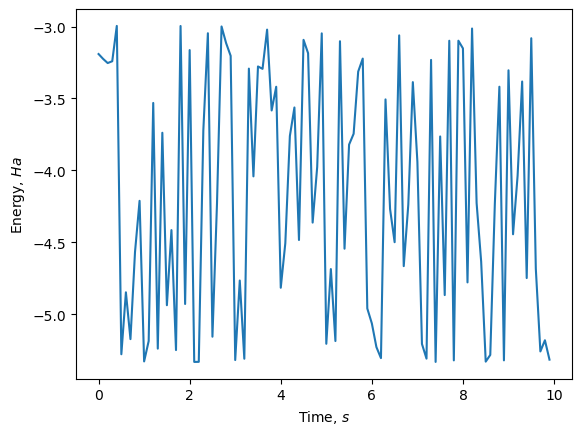

In [21]:
plt.plot(t,np.array(energies))
plt.xlabel('Time, $s$')
plt.ylabel('Energy, $Ha$')